In [3]:
import numpy as np 
import numpy.linalg as la
import matplotlib.pyplot as plt
from PIL import Image
from scipy.spatial.distance import cdist

In [4]:
 np.random.choice(10, size=10, replace=False)

array([8, 4, 1, 5, 3, 7, 0, 9, 6, 2])

In [11]:
def convert_png_to_array(png_file):
    '''converts a given png/jpg to an array
    requires numpy and Image from PIL
    '''
    image = Image.open(png_file) #load image
    array = np.asarray(image) #convert into array, n_pixel x n_pixels x 3 (red, green, blue)
    return array

def greyscale(array,method):
    '''
    Converts an RGB image array to greyscale using different methods. Input image of shape (n_pixels, m_pixels, 3) representing RGB values.
    method:
        - 'nor' : NTSC / perceptual weighting (0.3R + 0.59G + 0.11B)
        - 'avg' : Simple average of RGB channels
        - 'lim' : Luminance-based weighting (ITU-R BT.709)
        - 'lig' : Lightness method ((max(R,G,B) + min(R,G,B)) / 2)
    returns a 2D array of greyscale intensities. 
    '''
    greyscale_array = np.copy(array[:,:,0]) # Initialize greyscale array (copied from one channel to preserve shape/type)
    if method == 'nor': # 'nor' method: perceptual weighting based on human visual sensitivity
        greyscale_array = (array[:,:,0]*0.3               
                           +array[:,:,1]*0.59                    
                           +array[:,:,2]*0.11) 
    if method == 'avg': # 'avg' method: simple arithmetic mean of RGB channels
        greyscale_array = (array[:,:,0]+                    
                           array[:,:,1]+   
                           array[:,:,2])/3
    if method == 'lim': # 'lim' method: luminance-based conversion 
        greyscale_array = (array[:,:,0]*0.2126                       
                           +array[:,:,1]*0.7152                        
                           +array[:,:,2]*0.0722)
    if method == 'lig':  # 'lig' method: lightness conversion using HSL definition
        greyscale_array = (np.max(array[:,:,:],axis = 2)                 
                           + np.min(array[:,:,:],axis = 2))/2
    return greyscale_array #returns the array.

def uniformD(array, nx, my):
    '''
    Function takes as input the image converted to an array RGB (size: nxmx3) as well as the inputs nx and mx. Essentiall nx tells us we want every nx'th value in the x direction
    and my tells us we want every my'th value in the y direction. 
    '''
    n, m = array.shape[:2] #size of the image.
    Dpos = np.array([(xi, yi) for xi in np.arange(n)[::nx] for yi in np.arange(m)[::my]]) #we still need the positions
    rgb = array[Dpos[:,0], Dpos[:,1]]  # go into the array and get the RGB values. shape: (N, 3)
    D = np.hstack((Dpos, rgb))  # positions and RGB values into (N, 5)
    return D 

def randomD(array, N):
    '''
    Function takes as input the image converted to an array RGB (size: nxmx3 ), as well as the number of points
    N that we want to generate with colour. Then the function returns the position of those random points. It then goes into the array
    at those points to extract RGB colour, and then returns D which is a list of vecotrs of the form  (x,y, R, G, B). No repeated values. 
    '''
    n, m = array.shape[:2] #get the number of pixels in the x and y axis. 
    num_pixels = n * m #the total number of pixels
    
    # Randomly pick N unique indices from the total pool
    # replace=False ensures no duplicates
    indices = np.random.choice(num_pixels, size=N, replace=False) #the idea is that there are exactly nxm pixels positions possible, and there is a 
    # 1-to-1 relationship between: flat index and (row, col)

    rows = indices // m #integer division, throw away remainder
    cols = indices % m #get remainder
    #clearly if two different numbers have the same remaineder and and integer division then they are the same number
    Dpos = np.column_stack((rows, cols)) #stacks the positions in the way we want
    
    rgb = array[rows, cols] #extract the RGB colours we know at the positions Dpos
    
    D = np.hstack((Dpos, rgb)) #combine in (x, y, R, G, B) x N
    return D

def chooseD(image, N=None):
    return D


def overlay(greyscale_array,D):
    '''given the greyscale, and some information at points D this function returns an overlayed array so that one can plot the greyscaled overlayed with the colour information'''
    overlay = np.stack([greyscale_array, greyscale_array, greyscale_array], axis=2).astype(np.uint8) #axis 2 because we want this to be of shape (x,y, 3) and then we have
    #.astype(np.uint8) to ensure that the values are in between 0 and 255, strictly not needed
    for x, y, R, G, B in D: #loop over the values of D
        overlay[x, y] = [R, G, B] # Inject known color pixels
    return overlay #return the overlay
    

With these basic functions defined we can now plot the original image, the greyscale image, and the overlay given D. 

Let $\Omega = \{z_1, \dots, z_m\}$ be the points with greyscale information, and $D = \{x_1, \dots, x_n\}$ be the points with colour info given by $f: D \rightarrow I^3$. Clearly $n \ll m$. Let the color info at $x_i$ be $(f_i^r, f_i^g, f_i^b)$. 

We want to find $F : \Omega \rightarrow I^3$ such that $F(D) \approx f(D)$. i.e. a map that takes the position and outputs the colour information, with the constraint that if we input the domain D we get approximately the known colour. Let $F = (F^r, F^g, F^b)$

Assume that $F^r, F^g, F^b$ are independent of each other. We write $$F^s(x) = \sum^n_{j=1} k(x, x_j)a^s_j$$ for some coefficients $a_j^s, \quad 1 \leq j \leq n$ and with $s = r,g,b$. 

We define $K_\Omega\in \mathbb{R}^{m \times n}$, with $(K_\Omega)_{i,j} = k(z_i, x_j)$, so that the colour image can be computed using $F^s = K_\Omega a^s $. We can show that $F^s$ is a minimizer of a functional ... . Now let $K_D \in \mathbb{R}^{n \times n}$, then we just solve the problem $$(K_D + \delta n I)a^s = f^s$$ 

In [25]:
def phi_gaussian(r):
    '''
    Gaussian RBF: phi(r) = exp(-r^2).
    Accepts scalar or numpy array r and returns same-shaped array.
    '''
    return np.exp(-r*r) #we dont use np.power as r*r is faster.

def phi_wendland(r):
    '''
    Wendland function, where phi(r) = (1-r)^4_+ (4r+1)
    here _+ indicates that we take the positive part
    '''
    return np.power(np.maximum(1 - r, 0), 4) * (4*r + 1)

    

def kernel(phi, x, y, greyscale_map ,sig1 = 100, sig2 = 100, p = 0.5):
    '''
    Compute kernel matrix K of shape (m, n) where
    K_ij = phi( ||x_i - y_j||_2 / sig1 ) * phi( |g(x_i) - g(y_j)|^p / sig2 )

    Inputs
    - phi: radial basis function that accepts numpy arrays (elementwise).
    - x: array-like of shape (m, 2) giving positions (row, col) or (x,y).
    - y: array-like of shape (n, 2).
    - greyscale_map: 2D numpy array (image) where greyscale_map[row, col] is intensity in 0..255.
    - sig1, sig2: positive scale factors (floats).
    - p: exponent for greyscale difference (float).

    Returns
    - K: numpy array shape (m, n)
    '''
    input1 =  cdist(x, y, metric="euclidean")  / sig1  #first input to the radial basis function. 
    # cdist is a scipy function: Computes the l2 norm comapring each vector to each vector, this returns as m x n matrix, where for example x 
    # has m vectors and y has n vectors. 
    
    greyscale_x = greyscale_map[x[:,0], x[:,1]] #finds the value of the greyscale from 0 to 255 at x
    greyscale_y = greyscale_map[y[:,0], y[:,1]] #finds the value of the greyscale from 0 to 255 at y
    input2 = ((np.abs(greyscale_x[:,None] - greyscale_y[None,:])) **  p) / sig2 #second input to the radial basis function
    K = phi(input1) *  phi(input2) #compute the kernel this is t
    
    return K 


def compute_as(D, greyscale, phi,delta=2*1e-4, **kwargs):
    '''
    This function computes a_s. Input is D, the positions and known colours. Phi is the radial basis function we want to use. Delta is a constant. **kwargs are the arguments that
    we may choose or not choose to pass to the kernel function, i.e. sig1, sig2 and p.
    Solves the problem: 
    (K_D + delta*n*I)a_s = f_s
    solves for a_s and returns this. 
    '''
    KD = kernel(phi, D[:, :2], D[:, :2], greyscale, **kwargs)  #call kernel building function to build the matrix K_D. 
    f_s = D[:, 2:]  #extract the known colours from D. Recall D = [position_x, position_y, R, G, B]
    n = len(f_s)  #the number n. i.e. the number of known positions with colour
    a_s = la.solve(KD + delta * n * np.eye(n), f_s) #solve 
    #notice here we are solving 3 problems, for s = r, g, and b. so a_s is of shape [n,3]
    return a_s


def get_Fs(Komega, a_s):
    '''
    solve for Fs
    uses Fs = Komega * a_s
    '''
    Fs =  Komega @ a_s #compute
    return Fs

In [8]:
#plotting function

def plot(original, greyscale, overlay, colorization):
    '''
    simple plotting function to plot the original, greyscale, overlay and colorization images side by side. 
    '''
    plt.figure(figsize=(9, 9)) #set the figure size

    #original image subplot
    plt.subplot(2, 2, 1)
    plt.imshow(original)
    plt.title('Original')
    plt.axis('off')

    
    #greyscale subplot
    plt.subplot(2, 2, 2)
    plt.imshow(greyscale, cmap='gray',vmin =0, vmax=255)
    plt.title('Greyscale')
    plt.axis('off')

    #overlay of the points and the colours we know onto the greyscale plot
    plt.subplot(2, 2, 3)
    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')
    
    #colorization plot
    plt.subplot(2, 2, 4)
    plt.imshow(colorization)
    plt.title('Colorization')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    return

In [75]:
array = convert_png_to_array('peppers.png') #convert the image to array
greyscale_array = greyscale(array, method='nor') #convert the array to the greyscale array by specificing the method
#D = randomD(array, N=600) #generate D, the positions of known colour as well as the colours. 
D = uniformD(array, nx=30, my = 30) #generate D, the positions of known colour as well as the colours. 
overlay_array = overlay(greyscale_array,D) #generate the overlay'd array.

In [76]:
a_s = compute_as(D, greyscale_array, phi_gaussian,delta=2*1e-4) #compute the a_s, i.e. the weights? of the kernel? This is a [n,3]

In [83]:
rows = np.arange(greyscale_array.shape[0]) #number of rows in the array, i.e. number of pixels in y direction
cols = np.arange(greyscale_array.shape[1]) #number of columns in the array, i.e. umber of pixels in the x direction
R, C = np.meshgrid(rows, cols, indexing='ij') #greate a grid, here we generate R and C so that all rows pair to all columns
pairs = np.column_stack([R.reshape(-1), C.reshape(-1)]) #now we use R and C and shape it in the way we want.  .reshape(-1) changes it from matrix to column vector. 
Komega = kernel(phi_wendland, pairs, D[:,:2], greyscale_array,sig1 = 300, sig2 = 300, p = 0.5) # compute K_omega, i.e. the kernal matrix for our whole array

In [84]:
Fs = get_Fs(Komega, a_s).reshape(greyscale_array.shape[0],greyscale_array.shape[1],3)/255#compute the predicted colours, and also devided by 255 to give input to implot to be between 0 and 1 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


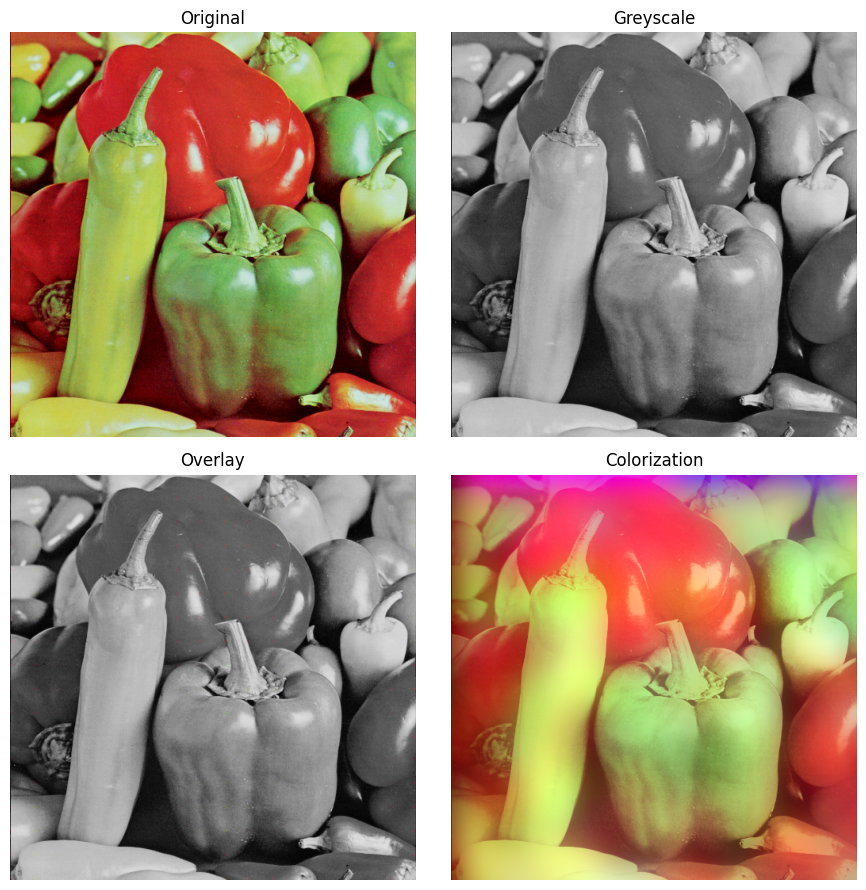

In [85]:
plot(array, greyscale_array, overlay_array, Fs)